In [ ]:
import pandas as pd
from google.colab import drive
import json

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load your JSON file
input_file_path = '/content/drive/My Drive/fyp/data-preprocess/identified_terms.json'

try:
    with open(input_file_path, 'r') as f:
        aspect_data = json.load(f)
    print("JSON file loaded successfully!")
except Exception as e:
    print(f"Error loading JSON file: {e}")

# 3. Create Aspect Lexicons
def create_aspect_lexicons(json_data):
    """
    Convert JSON structure to organized aspect lexicons
    Returns:
    - aspect_lexicons: Dictionary {category_name: set(keywords)}
    - category_map: Dictionary {keyword: category_name} for quick lookup
    """
    aspect_lexicons = {}
    category_map = {}

    if 'categories' in json_data:
        for category in json_data['categories']:
            category_name = category['name']
            keywords = set(category['keywords'])

            # Add to lexicons
            aspect_lexicons[category_name] = keywords

            # Add to reverse mapping
            for keyword in keywords:
                category_map[keyword] = category_name

    return aspect_lexicons, category_map

# Create the lexicons
aspect_lexicons, category_map = create_aspect_lexicons(aspect_data)

# 4. Verify the output
print("\nGenerated Aspect Lexicons:")
for category, keywords in aspect_lexicons.items():
    print(f"{category}: {len(keywords)} keywords")
    print(f"Sample keywords: {list(keywords)[:5]}...\n")

# 5. Convert to DataFrame for better visualization (optional)
df_lexicons = pd.DataFrame([
    (category, keyword)
    for category, keywords in aspect_lexicons.items()
    for keyword in keywords
], columns=['Category', 'Keyword'])

print("\nDataFrame representation:")
print(df_lexicons.head())

# 6. Save the processed lexicons (optional)
output_path = '/content/drive/My Drive/fyp/data-preprocess/processed_lexicons.json'
with open(output_path, 'w') as f:
    json.dump({
        'aspect_lexicons': {k: list(v) for k, v in aspect_lexicons.items()},
        'category_map': category_map
    }, f, indent=2)

print(f"\nLexicons saved to {output_path}")

Mounted at /content/drive
JSON file loaded successfully!

Generated Aspect Lexicons:
Attractions & Locations: 31 keywords
Sample keywords: ['valleys', 'caves', 'hiking trails', 'landmark', 'view']...

Culture & Heritage: 28 keywords
Sample keywords: ['old architecture', 'local', 'tradition', 'temple paintings', 'music']...

Cost & Budgeting: 23 keywords
Sample keywords: ['meal prices', 'cost', 'luxury', 'seasonal pricing', 'currency exchange']...

Accessibility & Transportation: 27 keywords
Sample keywords: ['difficult', 'bus routes', 'access', 'inconvenient', 'rural access']...

Safety & Security: 28 keywords
Sample keywords: ['tourist scams', 'risk', 'road safety', 'traveler support', 'political stability']...

Accommodation & Stays: 28 keywords
Sample keywords: ['bungalow', 'hotel', 'backpacker lodges', 'hostel', 'family-friendly']...

Food & Dining: 28 keywords
Sample keywords: ['kid-friendly menu', 'meal', 'food', 'seafood', 'dining']...

Hygiene & Sanitation: 26 keywords
Sample k

In [ ]:
!pip install nltk spacy fuzzywuzzy transformers rapidfuzz numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
JSON file loaded successfully!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Analysis Results:
                     aspect_term                        category  sentiment  \
0                          beach         Attractions & Locations      -0.32   
0                           room           Accommodation & Stays      -0.38   
0                       customer  Customer Service & Hospitality      -0.82   
1                        service  Customer Service & Hospitality      -0.82   
2  but terrible customer service  Customer Service & Hospitality      -0.82   
0                 very good food                   Food & Dining       0.74   
1                           food                   Food & Dining       0.49   
0                         temple         Attractions & Locations       0.00   
0                         street                   Food & Dining      -0.23   
1                          money                Cost & Budgeting      -0.23   
2                     local shop              Culture & Heritage      -0.23   
3                           shop 

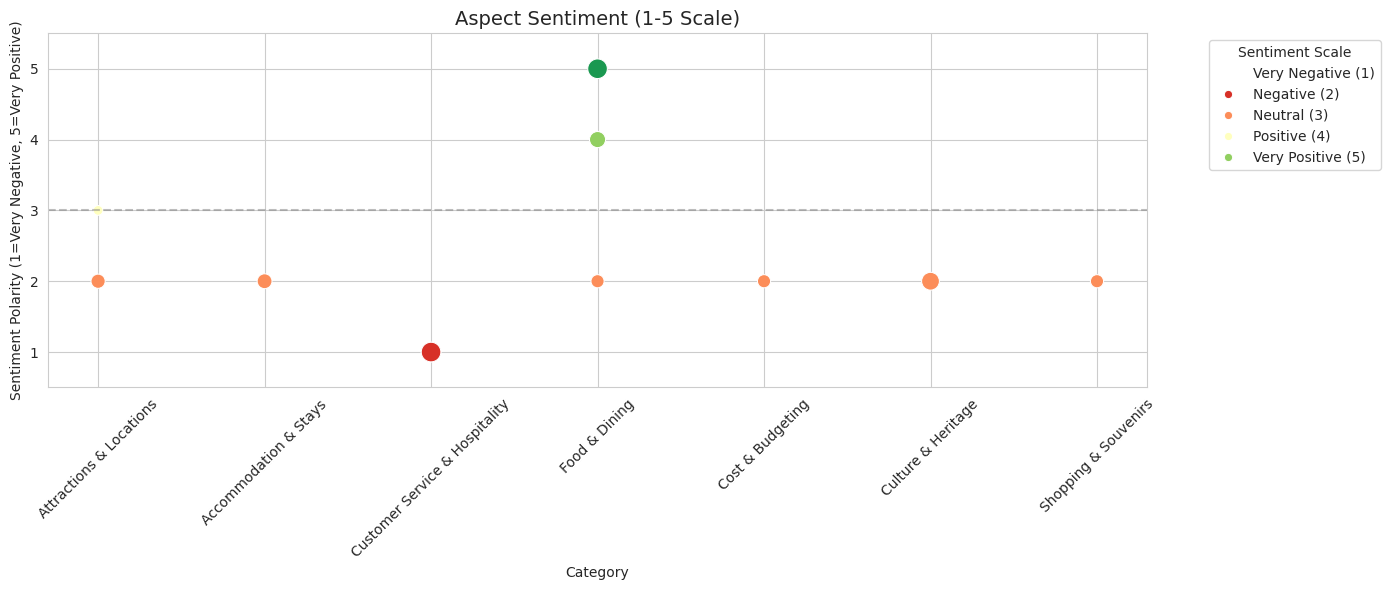


Dataset Analysis:
                       Location  \
0  Arugam Bay, Eastern Province   
1  Arugam Bay, Eastern Province   
2  Arugam Bay, Eastern Province   
3  Arugam Bay, Eastern Province   
4  Arugam Bay, Eastern Province   

                                              Review  \
0  I had a really professional and clean manicure...   
1  Overall, it is a wonderful experience. We visi...   
2  Great place to chill, swim, surf, eat, shop, h...   
3  Good place for surf but  few stores to going f...   
4  This place is great for surfing.  You can have...   

                                 Categorized_Aspects  
0  Wellness & Relaxation-3, Wellness & Relaxation...  
1  Hygiene & Sanitation-5, Attractions & Location...  
2  Nightlife & Entertainment-5, Nightlife & Enter...  
3  Weather & Climate-5, Shopping & Souvenirs-4, A...  
4  Culture & Heritage-5, Wildlife & Nature Experi...  

Results saved to /content/drive/My Drive/fyp/data-preprocess/Tourist_Review_dataset_label_final.csv


In [ ]:
import pandas as pd
from google.colab import drive
import json
import nltk
import spacy
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from rapidfuzz import fuzz
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Load and Process JSON Data
input_file_path = '/content/drive/My Drive/fyp/data-preprocess/identified_terms.json'

try:
    with open(input_file_path, 'r') as f:
        aspect_data = json.load(f)
    print("JSON file loaded successfully!")
except Exception as e:
    print(f"Error loading JSON file: {e}")
    raise

def create_aspect_lexicons(json_data):
    aspect_lexicons = defaultdict(set)
    category_map = {}

    if 'categories' in json_data:
        for category in json_data['categories']:
            category_name = category['name']
            keywords = set(category['keywords'])

            # Expand with lemma forms
            expanded_keywords = set()
            for kw in keywords:
                expanded_keywords.add(kw)
                doc = nlp(kw)
                if len(doc) == 1:  # Single word
                    expanded_keywords.add(doc[0].lemma_)

            aspect_lexicons[category_name] = expanded_keywords
            for keyword in expanded_keywords:
                category_map[keyword] = category_name

    return aspect_lexicons, category_map

# Initialize NLP Components
nltk.download('vader_lexicon')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

# Load lexicons
aspect_lexicons, category_map = create_aspect_lexicons(aspect_data)

# Enhanced Dictionaries
negation_words = {'not', "n't", 'never', 'no', 'none', 'without', 'lack of', 'hardly'}
intensifiers = {
    'very': 1.5, 'extremely': 1.8, 'really': 1.3, 'absolutely': 1.7,
    'highly': 1.4, 'so': 1.3, 'too': 1.2, 'somewhat': 0.7,
    'slightly': 0.6, 'barely': 0.5, 'a bit': 0.6
}

def detect_aspects(text):
    doc = nlp(text.lower())
    aspects = set()
    all_keywords = [(kw, cat) for cat, kws in aspect_lexicons.items() for kw in kws]

    # Process noun chunks
    for chunk in doc.noun_chunks:
        chunk_text = ' '.join([token.lemma_ for token in chunk if token.text not in ['the', 'a', 'an']])
        if not chunk_text:
            continue

        # Find best matching category
        best_match, best_score = None, 0
        for kw, cat in all_keywords:
            score = fuzz.token_set_ratio(kw, chunk_text)
            if score > best_score and score > 75:
                best_score = score
                best_match = cat

        if best_match:
            aspects.add((chunk_text, best_match))

    # Process individual nouns
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and token.lemma_ not in ['the', 'a', 'an']:
            token_text = token.lemma_

            # Check direct matches first
            if token_text in category_map:
                aspects.add((token_text, category_map[token_text]))
                continue

            # Then fuzzy matches
            best_match, best_score = None, 0
            for kw, cat in all_keywords:
                if token_text in kw.split():  # Check if token is part of multi-word keyword
                    aspects.add((token_text, cat))
                    break
                score = fuzz.ratio(token_text, kw)
                if score > best_score and score > 80:
                    best_score = score
                    best_match = cat

            if best_match:
                aspects.add((token_text, best_match))

    return aspects

def get_sentiment(text, aspect_term, category):
    doc = nlp(text)
    aspect_sentences = [
        sent.text for sent in doc.sents
        if aspect_term.lower() in sent.text.lower()
    ]

    if not aspect_sentences:
        return 0.0

    sentiment_scores = []
    for sent in aspect_sentences:
        sent_doc = nlp(sent.lower())
        sentiment = sia.polarity_scores(sent)['compound']

        # Enhanced negation detection
        negation = any(
            (token.text in negation_words and
             any(t.text.lower() in aspect_term.lower().split()
                 for t in token.subtree))
            for token in sent_doc
        )

        # Dynamic intensifier handling
        intensifier = 1.0
        for token in sent_doc:
            if token.text in intensifiers:
                if any(t.text.lower() in aspect_term.lower().split()
                      for t in token.head.children):
                    intensifier = min(2.0, intensifier * intensifiers[token.text])

        # Apply adjustments
        if negation:
            sentiment = -sentiment * min(intensifier, 1.5)
        else:
            sentiment *= intensifier

        sentiment_scores.append(sentiment)

    # Weighted average by sentence length
    weights = [len(sent.split()) for sent in aspect_sentences]
    avg_sentiment = np.average(sentiment_scores, weights=weights) if sentiment_scores else 0.0

    # Dynamic category adjustment
    category_weights = {
        'default': 1.0
    }
    avg_sentiment *= category_weights.get(category, category_weights['default'])

    return np.clip(avg_sentiment, -1, 1).round(2)


def analyze_text(text):
    try:
        doc = nlp(str(text).lower())
        aspects = detect_aspects(text)
        results = []
        seen_lemmas = set()

        for aspect_term, category in aspects:
            # Consistent normalization
            clean_term = ' '.join([token.lemma_ for token in nlp(aspect_term)])
            clean_lemmas = frozenset(token.lemma_ for token in nlp(clean_term))

            if clean_lemmas in seen_lemmas:
                continue
            seen_lemmas.add(clean_lemmas)

            # Calculate confidence
            term_length = len(clean_term.split())
            sentiment = get_sentiment(text, clean_term, category)
            confidence = min(0.95, 0.5 + (term_length * 0.15) + (abs(sentiment) * 0.35))

            # Map to 1-5 scale
            if sentiment > 0.6:
                polarity = 5  # Very Positive
                polarity_label = "Very Positive"
            elif sentiment > 0.2:
                polarity = 4  # Positive
                polarity_label = "Positive"
            elif sentiment >= -0.2:
                polarity = 3  # Neutral
                polarity_label = "Neutral"
            elif sentiment > -0.6:
                polarity = 2  # Negative
                polarity_label = "Negative"
            else:
                polarity = 1  # Very Negative
                polarity_label = "Very Negative"

            results.append({
                'aspect_term': clean_term,
                'category': category,
                'sentiment': round(sentiment, 4),
                'polarity': polarity,
                'polarity_label': polarity_label,
                'confidence': round(confidence, 2)
            })

        return pd.DataFrame(results)
    except Exception as e:
        print(f"Error analyzing text: {str(e)[:100]}...")
        return pd.DataFrame()


# Test with examples
test_reviews = [
    "Nice sandy beach but very narrow, no sunbeds allowed on beach or chairs. Sea very tough with large waves.",
    "the room was somewhat dirty.",
    "But terrible customer service at the front desk.",
    "Very Good food",
    "The idol of the Nallur Devi or goddess was given to the temple in the 10th century CE by the Chola queen Sembiyan Mahadevi in the style of Sembian bronzes",
    "My husband walked to local shop on the main street at 10 am and was surrounded by old men demanding money"
]

results = pd.concat([analyze_text(review) for review in test_reviews])

if not results.empty:
    print("\nAnalysis Results:")
    print(results[['aspect_term', 'category', 'sentiment', 'polarity', 'confidence']])
else:
    print("No valid results generated")

# Updated Visualization for 1-5 Scale
if not results.empty:
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    # Create custom color palette for 1-5 scale
    sentiment_palette = {
        1: "#d73027",  # Very Negative (Red)
        2: "#fc8d59",  # Negative (Orange)
        3: "#ffffbf",  # Neutral (Yellow)
        4: "#91cf60",  # Positive (Light Green)
        5: "#1a9850"   # Very Positive (Dark Green)
    }

    # Plot each aspect's polarity
    ax = sns.scatterplot(
        x='category',
        y='polarity',
        hue='polarity',
        size='confidence',
        sizes=(50, 200),
        palette=sentiment_palette,
        data=results,
        legend='brief'
    )

    # Customize plot
    plt.title("Aspect Sentiment (1-5 Scale)", fontsize=14)
    plt.xlabel("Category")
    plt.ylabel("Sentiment Polarity (1=Very Negative, 5=Very Positive)")
    plt.ylim(0.5, 5.5)
    plt.axhline(3, color='gray', linestyle='--', alpha=0.5)  # Neutral baseline
    plt.xticks(rotation=45)

    # Create custom legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:5],
        ['Very Negative (1)', 'Negative (2)', 'Neutral (3)', 'Positive (4)', 'Very Positive (5)'],
        title="Sentiment Scale",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()




# Process dataset
data_path = '/content/drive/My Drive/fyp/data-preprocess/Tourist_Review_dataset_label.csv'
try:
    df = pd.read_csv(data_path, encoding="ISO-8859-1").head(10)

    def analyze_review(review):
        analysis = analyze_text(review)
        if analysis.empty:
            return "No aspects detected"
        return ", ".join([
            f"{row['category']}-{row['polarity']}"
            for _, row in analysis.iterrows()
        ])

    df['Categorized_Aspects'] = df['Review'].apply(analyze_review)
    print("\nDataset Analysis:")
    print(df[['Location', 'Review', 'Categorized_Aspects']].head())

    # Save results
    output_path = '/content/drive/My Drive/fyp/data-preprocess/Tourist_Review_dataset_label_final.csv'
    df.to_csv(output_path, index=False)
    print(f"\nResults saved to {output_path}")

except Exception as e:
    print(f"Error processing dataset: {e}")

In [ ]:
from nltk.corpus import wordnet as wn
import nltk
import random
import re

nltk.download('wordnet')
nltk.download('omw-1.4')

class GrammarSafeReviewAugmenter:
    def __init__(self):
        # Carefully curated negation words (as set)
        self.negation_words = {
            'not', "n't", 'never', 'no',
            "don't", "doesn't", "isn't", "aren't", "wasn't", "weren't"
        }

        # Intensifiers with set of keys (not dictionary)
        self.intensifiers = {
            'extremely', 'absolutely', 'incredibly',
            'very', 'highly', 'really',
            'somewhat', 'slightly', 'way'
        }

        # Intensifier strength scores (separate dictionary)
        self.intensifier_scores = {
            'extremely': 1.9, 'absolutely': 1.85, 'incredibly': 1.8,
            'very': 1.5, 'highly': 1.4, 'really': 1.3,
            'somewhat': 0.7, 'slightly': 0.6
        }

        # Grammar rules
        self.to_be_verbs = {'is', 'are', 'was', 'were'}
        self.auxiliary_verbs = {'do', 'does', 'did', 'have', 'has', 'had'}

        # Load adjectives
        self.adjectives = self._load_adjectives()

        # Patterns to skip augmentation
        self.skip_patterns = [
            r'\d+\s+\w+',  # matches any number followed by word
            r'\blast\b',   # matches the word "last" (whole word)
        ]

    def _load_adjectives(self):
        adjectives = set()
        for synset in wn.all_synsets(wn.ADJ):
            for lemma in synset.lemmas():
                adj = lemma.name().replace('_', ' ').lower()
                if ' ' not in adj:
                    adjectives.add(adj)
        return adjectives

    def _should_skip(self, text: str) -> bool:
        """Check if text matches any skip patterns"""
        text_lower = text.lower()
        for pattern in self.skip_patterns:
            if re.search(pattern, text_lower):
                return True
        return False

    def _add_negation(self, text: str) -> list:
        """Grammar-correct negation placement"""
        variants = []
        words = text.split()

        for i, word in enumerate(words):
            # Handle "to be" verbs (is/are/was/were)
            if word.lower() in self.to_be_verbs:
                variants.append(' '.join(words[:i] + [word, 'not'] + words[i+1:]))
                variants.append(' '.join(words[:i] + [word + "n't"] + words[i+1:]))

            # Handle auxiliary verbs (do/does/did)
            elif word.lower() in self.auxiliary_verbs:
                variants.append(' '.join(words[:i] + [word, 'not'] + words[i+1:]))

        return variants

    def _add_intensifiers(self, text: str) -> list:
        """Add intensifiers only before adjectives"""
        variants = []
        words = text.split()

        for i, word in enumerate(words):
            if word.lower() in self.adjectives:
                # Check previous word isn't an intensifier or negation
                if i == 0 or words[i-1].lower() not in (self.intensifiers | self.negation_words):
                    for intense in self.intensifiers:
                        variants.append(' '.join(words[:i] + [intense] + words[i:]))

        return variants

    def augment(self, text: str) -> list:
        """Generate clean, grammatical variants"""
        if self._should_skip(text):
            return [text]

        variants = [text]

        # Generate negations first
        negated = [v for v in self._add_negation(text) if self._is_grammatical(v)]
        variants.extend(negated)

        # Then intensify original and negated versions
        for v in [text] + negated:
            variants.extend(self._add_intensifiers(v))

        # Remove duplicates and sort
        return sorted(list(set(variants)), key=lambda x: (len(x), x))

    def _is_grammatical(self, text: str) -> bool:
        """Basic grammar validation"""
        words = text.lower().split()

        # Check for consecutive negations
        negation_count = sum(1 for w in words if w in self.negation_words)
        if negation_count > 1:
            return False

        # Check for negation + intensifier conflicts
        has_negation = any(w in self.negation_words for w in words)
        has_intensifier = any(w in self.intensifiers for w in words)
        if has_negation and has_intensifier:
            return False

        return True

# Testing
augmenter = GrammarSafeReviewAugmenter()

print("="*40)
print("Testing with phrases that should not augment:")
skip_phrases = [
    "Spent 2 nights in Arugam Bay",  # contains number
    "Last morning was perfect",      # contains "last"
    "We stayed for 5 days",         # contains number
    "Last year's vacation",         # contains "last"
    "3 people in our group"         # contains number
]
for phrase in skip_phrases:
    print(f"\nOriginal: {phrase}")
    print("Augmented:", augmenter.augment(phrase))

print("\n" + "="*40)
print("Testing with regular phrases (should augment):")
regular_phrases = [
    "I had a really professional and clean manicure, and the location right on the ocean made it very relaxing. My consultant was very helpful with local knowledge. I plan to return for a massage and foot massage."
]
for phrase in regular_phrases:
    print(f"\nOriginal: {phrase}")
    print("Augmented:", augmenter.augment(phrase))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Testing with phrases that should not augment:

Original: Spent 2 nights in Arugam Bay
Augmented: ['Spent 2 nights in Arugam Bay']

Original: Last morning was perfect
Augmented: ['Last morning was perfect']

Original: We stayed for 5 days
Augmented: ['We stayed for 5 days']

Original: Last year's vacation
Augmented: ["Last year's vacation"]

Original: 3 people in our group
Augmented: ['3 people in our group']

Testing with regular phrases (should augment):

Original: I had a really professional and clean manicure, and the location right on the ocean made it very relaxing. My consultant was very helpful with local knowledge. I plan to return for a massage and foot massage.
Augmented: ['I had a really professional and clean manicure, and the location right on the ocean made it very relaxing. My consultant was very helpful with local knowledge. I plan to return for a massage and foot massage.', 'I had a really professional and clean manicure, and the location right on the ocean made it ver